In [ ]:
# Flexynesis

In [2]:
## data import
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

In [3]:
# Functions

In [4]:
# Functions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os


def prepare_and_save_data(test_size=0.3, random_seed=42, debug=True):

    load_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\preprocessed data"
    metadata_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\sample data.xlsx"
    save_base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"

    # 读取数据
    HDF = pd.read_csv(os.path.join(load_path, "S_HDF.csv"), index_col=0)
    LD  = pd.read_csv(os.path.join(load_path, "S_LD.csv"), index_col=0)
    PM  = pd.read_csv(os.path.join(load_path, "S_PM.csv"), index_col=0)
    BM  = pd.read_csv(os.path.join(load_path, "S_BM.csv"), index_col=0)
    metadata = pd.read_excel(metadata_path)

    metadata['SampleId'] = metadata['SampleId'].astype(int)
    HDF.index = HDF.index.astype(int)

    merged_df = HDF.merge(
        metadata[['SampleId', 'SEX', 'DIAB', 'AGE', 'BMI']],
        left_index=True,
        right_on='SampleId'
    )
    merged_df['SEX_num'] = merged_df['SEX'].str.strip().str.lower().map({'female': 1, 'male': 0})
    merged_df['DIAB_num'] = merged_df['DIAB'].str.strip().str.lower().map({'diabetic': 1, 'non-diabetic': 0})
    y_dm = merged_df['DIAB_num']
    y_dm.index = HDF.index

    # ========== 调试模式：缩小样本数和特征数 ==========
    if debug:
        n_sample_debug = 80
        n_feature_debug = 100
        print(f"🧪 Debug mode active: Using {n_sample_debug} samples and {n_feature_debug} features per omic")

        # 使用train_test_split实现分层采样，抽取n_sample_debug个样本
        sample_ids, _ = train_test_split(
            y_dm.index,
            train_size=n_sample_debug,
            stratify=y_dm,
            random_state=random_seed
        )
        # 用抽样后的id过滤数据
        HDF = HDF.loc[sample_ids]
        LD = LD.loc[sample_ids]
        PM = PM.loc[sample_ids]
        BM = BM.loc[sample_ids]
        y_dm = y_dm.loc[sample_ids]
        metadata = metadata[metadata['SampleId'].isin(sample_ids)]

        print("调试模式下抽样后类别分布：")

        # 截取特征前 N 个
        HDF = HDF.iloc[:, :n_feature_debug]
        LD = LD.iloc[:, :n_feature_debug]
        PM = PM.iloc[:, :n_feature_debug]
        BM = BM.iloc[:, :n_feature_debug]

    # print(y_dm.head(20))
    print(y_dm.value_counts())
    # print(HDF)

    # ========== 划分数据 ==========
    HDF_train, HDF_test, y_train, y_test = train_test_split(
        HDF, y_dm, test_size=test_size, random_state=random_seed
    )
    LD_train = LD.loc[HDF_train.index]
    LD_test  = LD.loc[HDF_test.index]
    PM_train = PM.loc[HDF_train.index]
    PM_test  = PM.loc[HDF_test.index]
    BM_train = BM.loc[HDF_train.index]
    BM_test  = BM.loc[HDF_test.index]
    Y_train = y_dm.loc[HDF_train.index]
    Y_test  = y_dm.loc[HDF_test.index]

    # 保存路径准备
    train_path = os.path.join(save_base_path, "train")
    test_path = os.path.join(save_base_path, "test")
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # 保存函数
    def save_train(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_test(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)
    
    def save_clinical_train(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_clinical_test(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)

    

    # 保存训练集
    save_train(LD_train, "LD", "LD")
    save_train(PM_train, "PM", "PM")
    save_train(BM_train, "BM", "BM")
    save_train(HDF_train, "HDF", "HDF")
    save_clinical_train(Y_train, "clin")

    # 保存测试集
    save_test(LD_test, "LD", "LD")
    save_test(PM_test, "PM", "PM")
    save_test(BM_test, "BM", "BM")
    save_test(HDF_test, "HDF", "HDF")
    save_clinical_test(Y_test, "clin")

    print(f"[✓] Split ratio: {1 - test_size:.2f} train / {test_size:.2f} test | seed={random_seed}")

prepare_and_save_data(test_size=0.3,random_seed=48)

🧪 Debug mode active: Using 80 samples and 100 features per omic
调试模式下抽样后类别分布：
DIAB_num
1    43
0    37
Name: count, dtype: int64
[✓] Split ratio: 0.70 train / 0.30 test | seed=48


In [1]:
#保存文件
import os
import pandas as pd
import numpy as np
from flexynesis import HyperparameterTuning, DirectPred, DataImporter, evaluate_wrapper

def run_stability_test_metrics_only(data_types=['BM', 'HDF']):
    # 固定的参数配置
    test_sizes = [0.3]
    seeds = [0, 1, 48, 42, 2023]
    base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"

    all_metrics = []

    for test_size in test_sizes:
        for seed in seeds:
            print(f"\n🔁 Running for test_size={test_size}, seed={seed}")

            # 预处理数据
            prepare_and_save_data(test_size=test_size, random_seed=seed, debug=False)

            # 导入数据
            data_importer = DataImporter(
                path=base_path,
                data_types=data_types,
                concatenate=False,
                top_percentile=100,
                min_features=100,
                variance_threshold=0.0,
            )
            train_dataset, test_dataset, _ = data_importer.import_data()

            # 超参数调优（这里只做1次迭代）
            tuner = HyperparameterTuning(
                dataset=train_dataset,
                model_class=DirectPred,
                target_variables=["clin"],
                config_name="DirectPred",
                n_iter=3,
                cv_splits=3,
                plot_losses=False,
                early_stop_patience=5
            )
            model, _, _ = tuner.perform_tuning()

            # 模型预测与评估
            y_pred_dict = model.predict(test_dataset)
            metrics_df = evaluate_wrapper(method='DirectPred', y_pred_dict=y_pred_dict, dataset=test_dataset)

            # 添加额外信息：test_size 和 seed
            metrics_df["test_size"] = test_size
            metrics_df["seed"] = seed
            all_metrics.append(metrics_df)

    # 合并所有结果
    final_metrics_df = pd.concat(all_metrics, ignore_index=True)

    # 重塑为每个 seed 一行，每个 metric 一个列的 wide format
    pivot_metrics_df = final_metrics_df.pivot_table(
        index='seed',
        columns='metric',
        values='value'
    ).reset_index()

    print(f"\n✅ Stability test finished. {len(pivot_metrics_df)} rows of metrics collected.")

    # ✅ 保存结果为 CSV，文件名基于 data_types 拼接
    filename = "_".join(data_types) + ".csv"
    output_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, filename)
    pivot_metrics_df.to_csv(file_path, index=False)
    print(f"📁 Results saved to: {file_path}")

    return pivot_metrics_df


Seed set to 42


In [16]:
import os
import pandas as pd
import numpy as np
from flexynesis import HyperparameterTuning, DirectPred, DataImporter, evaluate_wrapper

def run_stability_test_metrics_only(data_types=['BM', 'HDF']):
    # 固定的参数配置
    test_sizes = [0.3]
    seeds = [0, 1, 48, 42, 2023]
    base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"

    all_metrics = []

    for test_size in test_sizes:
        for seed in seeds:
            print(f"\n🔁 Running for test_size={test_size}, seed={seed}")

            # 预处理数据
            prepare_and_save_data(test_size=test_size, random_seed=seed, debug=False)

            # 导入数据
            data_importer = DataImporter(
                path=base_path,
                data_types=data_types,
                concatenate=False,
                top_percentile=100,
                min_features=100,
                variance_threshold=0.0,
            )
            train_dataset, test_dataset, _ = data_importer.import_data()

            # 超参数调优（这里只做1次迭代）
            tuner = HyperparameterTuning(
                dataset=train_dataset,
                model_class=DirectPred,
                target_variables=["clin"],
                config_name="DirectPred",
                n_iter=3,
                cv_splits=3,
                plot_losses=False,
                early_stop_patience=5
            )
            model, _, _ = tuner.perform_tuning()

            # 模型预测与评估
            y_pred_dict = model.predict(test_dataset)
            metrics_df = evaluate_wrapper(method='DirectPred', y_pred_dict=y_pred_dict, dataset=test_dataset)

            # 添加额外信息：test_size 和 seed
            metrics_df["test_size"] = test_size
            metrics_df["seed"] = seed
            all_metrics.append(metrics_df)

    # 合并所有结果
    final_metrics_df = pd.concat(all_metrics, ignore_index=True)

    # 重塑为每个 seed 一行，每个 metric 一个列的 wide format
    pivot_metrics_df = final_metrics_df.pivot_table(
        index='seed',
        columns='metric',
        values='value'
    ).reset_index()

    print(f"\n✅ Stability test finished. {len(pivot_metrics_df)} rows of metrics collected.")
    return pivot_metrics_df


# ✅ 调用例子
# metrics_df = run_stability_test_metrics_only(data_types=['BM', 'HDF'])
# print(metrics_df.head())


# 1 block

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.9740464687347412     │
│         val_loss          │    0.9740464687347412     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:16<00:00, 45.45s/it, Iteration=3, Best Loss=0.588]

[INFO] current best val loss: 0.5877850651741028; best params: {'latent_dim': 58, 'hidden_dim_factor': 0.4647196983949791, 'lr': 0.00766943772019061, 'supervisor_hidden_dim': 22, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


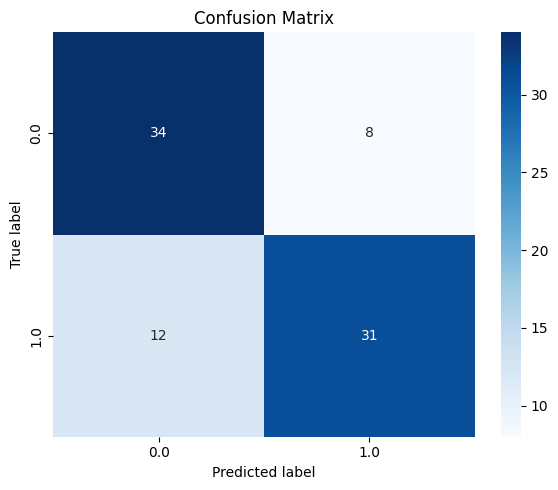


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF.csv


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.829276,0.812709,0.741360,0.741536,0.480844,0.742716,0.741176
1,1,0.865864,0.871397,0.819568,0.820838,0.643954,0.837576,0.823529
2,42,0.893822,0.905797,0.843088,0.846415,0.690216,0.847919,0.847059
3,48,0.880080,0.850056,0.745262,0.741391,0.484848,0.749020,0.741176
4,2023,0.812824,0.858250,0.765227,0.764315,0.529867,0.767329,0.764706


In [9]:
# HDF
HDF = run_stability_test_metrics_only(data_types=['HDF'])
HDF

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    1.0679943561553955     │
│         val_loss          │    1.0679943561553955     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:04<00:00, 41.66s/it, Iteration=3, Best Loss=1.07]

[INFO] current best val loss: 1.0679943561553955; best params: {'latent_dim': 59, 'hidden_dim_factor': 0.4703260069660239, 'lr': 0.007854610081419433, 'supervisor_hidden_dim': 24, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


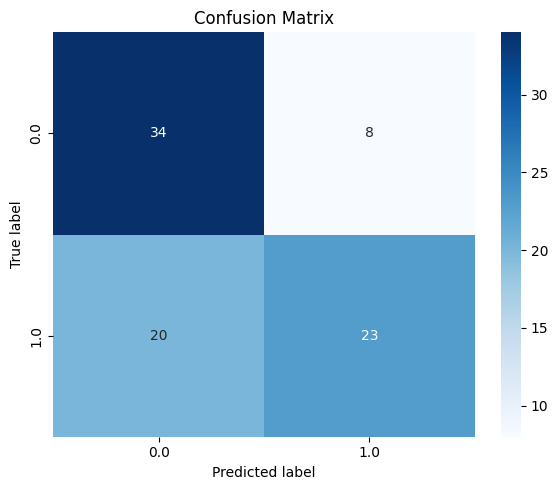


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\LD.csv


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.834505,0.794872,0.709588,0.685592,0.404954,0.745599,0.694118
1,1,0.793888,0.798780,0.720621,0.716078,0.438326,0.727464,0.717647
2,42,0.855289,0.837235,0.762263,0.767955,0.538176,0.800299,0.776471
3,48,0.768085,0.741360,0.665273,0.657973,0.324843,0.672118,0.658824
4,2023,0.750684,0.790698,0.672204,0.664467,0.343267,0.686443,0.670588


In [10]:
# LD
LD = run_stability_test_metrics_only(data_types=['LD'])
LD

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.29779157042503357    │
│         val_loss          │    0.29779157042503357    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:02<00:00, 40.93s/it, Iteration=3, Best Loss=0.298]

[INFO] current best val loss: 0.29779157042503357; best params: {'latent_dim': 58, 'hidden_dim_factor': 0.47047204552030025, 'lr': 0.00897768024614235, 'supervisor_hidden_dim': 24, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


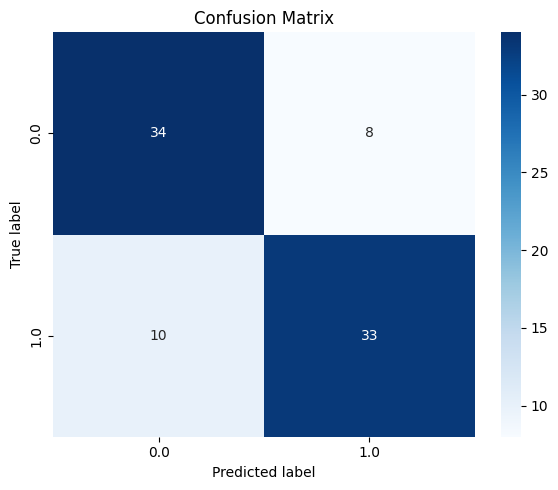


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\BM.csv


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.895951,0.884615,0.784838,0.787702,0.571908,0.788050,0.788235
1,1,0.899167,0.896896,0.810698,0.811503,0.622432,0.812145,0.811765
2,42,0.946505,0.960981,0.905240,0.905882,0.810479,0.905882,0.905882
3,48,0.855781,0.871237,0.802676,0.808538,0.614949,0.820536,0.811765
4,2023,0.917194,0.906977,0.788483,0.788177,0.576646,0.788992,0.788235


In [11]:
# BM
BM = run_stability_test_metrics_only(data_types=['BM'])
BM

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.9419741630554199     │
│         val_loss          │    0.9419741630554199     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:01<00:00, 40.58s/it, Iteration=3, Best Loss=0.567]


[INFO] current best val loss: 0.567393958568573; best params: {'latent_dim': 58, 'hidden_dim_factor': 0.4631048049186143, 'lr': 0.007469285570915421, 'supervisor_hidden_dim': 25, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


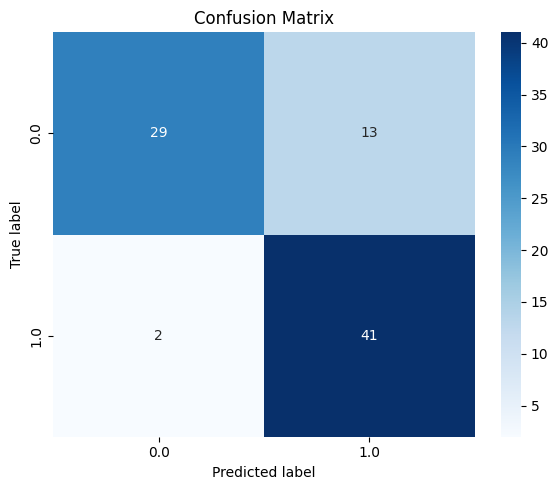


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\PM.csv


In [12]:
# PM
PM = run_stability_test_metrics_only(data_types=['PM'])

# 2 blocks

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    1.0909055471420288     │
│         val_loss          │    1.0909055471420288     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:12<00:00, 44.19s/it, Iteration=3, Best Loss=0.39]

[INFO] current best val loss: 0.39019355177879333; best params: {'latent_dim': 59, 'hidden_dim_factor': 0.4744857061625282, 'lr': 0.00914417747021431, 'supervisor_hidden_dim': 22, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


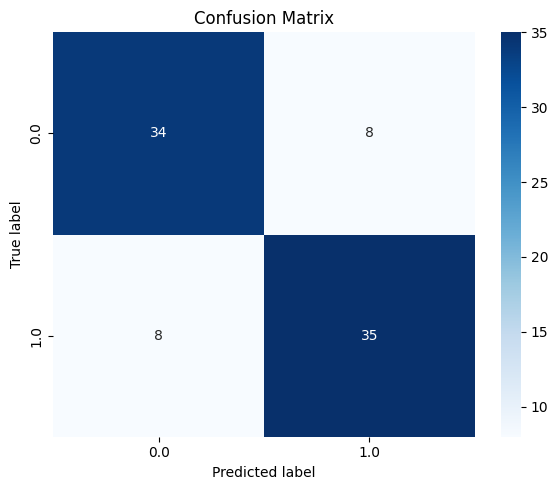


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF_LD.csv


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.861347,0.850056,0.795708,0.799158,0.594898,0.800340,0.800000
1,1,0.810900,0.840355,0.736696,0.736408,0.477362,0.753264,0.741176
2,42,0.901573,0.906355,0.830268,0.834274,0.665730,0.837042,0.835294
3,48,0.869962,0.853400,0.779822,0.776780,0.554237,0.782470,0.776471
4,2023,0.878797,0.887043,0.811739,0.811765,0.623477,0.811765,0.811765


In [14]:
# HDF_LD
HDF_LD = run_stability_test_metrics_only(data_types=['HDF','LD'])
HDF_LD

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.7695525288581848     │
│         val_loss          │    0.7695525288581848     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:02<00:00, 40.71s/it, Iteration=3, Best Loss=0.72]

[INFO] current best val loss: 0.7199090123176575; best params: {'latent_dim': 59, 'hidden_dim_factor': 0.47919153288642063, 'lr': 0.008330433226612094, 'supervisor_hidden_dim': 22, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


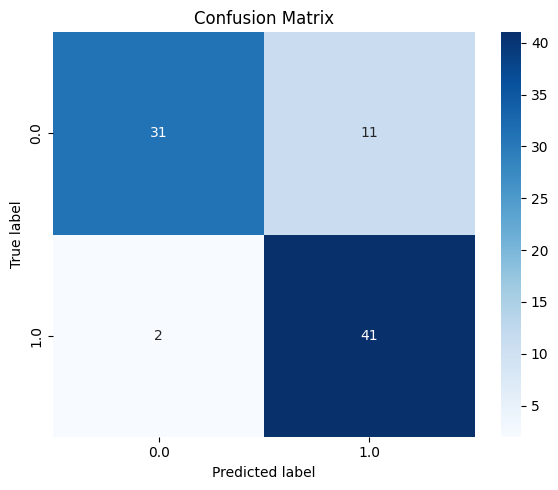


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF_PM.csv


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.910768,0.887960,0.778986,0.784605,0.566818,0.795713,0.788235
1,1,0.876153,0.875277,0.794346,0.794031,0.595125,0.829323,0.800000
2,42,0.942660,0.958751,0.905240,0.905882,0.810479,0.905882,0.905882
3,48,0.908589,0.909699,0.784002,0.790209,0.585128,0.838934,0.800000
4,2023,0.826458,0.861019,0.845792,0.845127,0.693311,0.863040,0.847059


In [15]:
# HDF_PM
# HDF_PM
HDF_PM = run_stability_test_metrics_only(data_types=['HDF', 'PM'])
HDF_PM

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    1.0640817880630493     │
│         val_loss          │    1.0640817880630493     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [01:55<00:00, 38.62s/it, Iteration=3, Best Loss=0.64]

[INFO] current best val loss: 0.6403605341911316; best params: {'latent_dim': 57, 'hidden_dim_factor': 0.4634369696265419, 'lr': 0.008788331936046391, 'supervisor_hidden_dim': 24, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


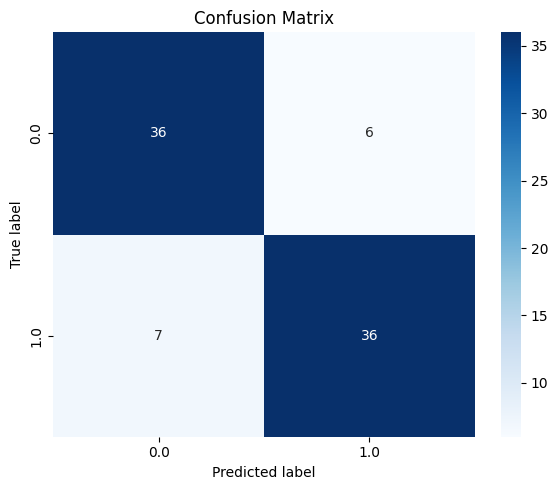


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF_BM.csv


In [16]:
# HDF_BM
HDF_BM = run_stability_test_metrics_only(data_types=['HDF', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.9371241927146912     │
│         val_loss          │    0.9371241927146912     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [01:57<00:00, 39.05s/it, Iteration=3, Best Loss=0.697]

[INFO] current best val loss: 0.6971994638442993; best params: {'latent_dim': 57, 'hidden_dim_factor': 0.47600006963527364, 'lr': 0.008525374180113421, 'supervisor_hidden_dim': 23, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


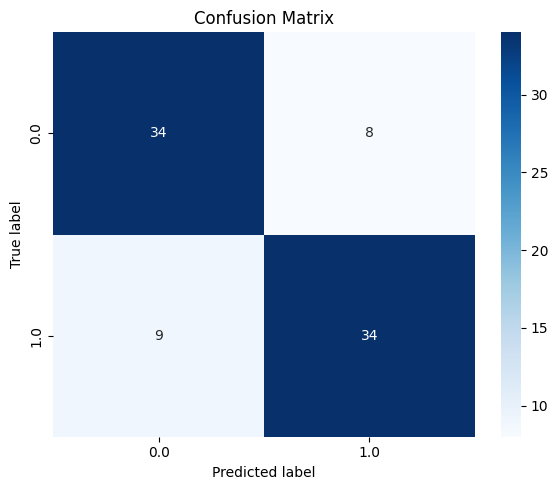


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\LD_PM.csv


In [17]:
# LD_PM
LD_PM = run_stability_test_metrics_only(data_types=['LD', 'PM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.6092021465301514     │
│         val_loss          │    0.6092021465301514     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:05<00:00, 41.95s/it, Iteration=3, Best Loss=0.609]

[INFO] current best val loss: 0.6092021465301514; best params: {'latent_dim': 58, 'hidden_dim_factor': 0.4621411435710837, 'lr': 0.00818962269751127, 'supervisor_hidden_dim': 24, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


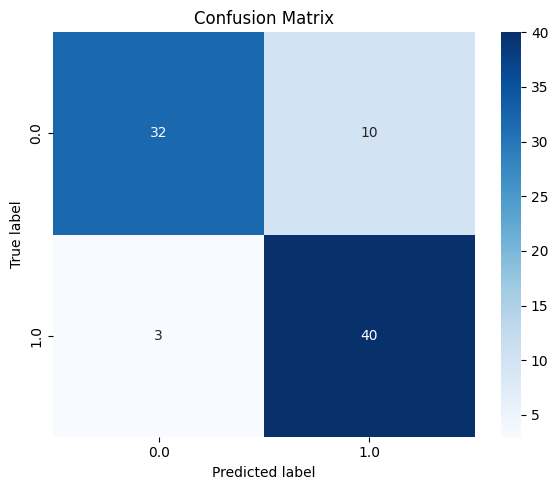


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\LD_BM.csv


In [18]:
# LD_BM
LD_BM = run_stability_test_metrics_only(data_types=['LD', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.41116195917129517    │
│         val_loss          │    0.41116195917129517    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [01:58<00:00, 39.40s/it, Iteration=3, Best Loss=0.411]

[INFO] current best val loss: 0.41116195917129517; best params: {'latent_dim': 59, 'hidden_dim_factor': 0.4602772427182572, 'lr': 0.008824459048835533, 'supervisor_hidden_dim': 24, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


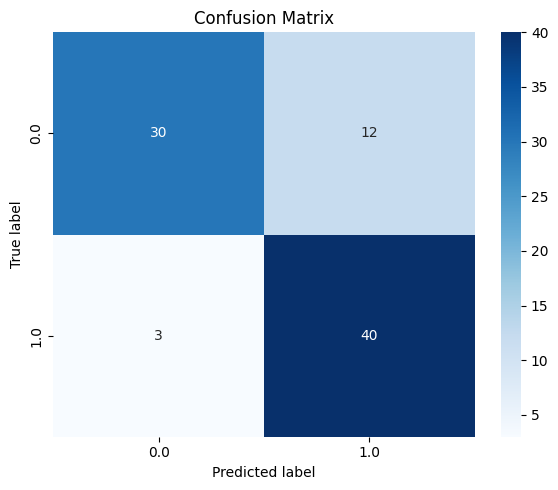


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\PM_BM.csv


metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.941270,0.925307,0.800725,0.807151,0.613417,0.826905,0.811765
1,1,0.931273,0.920732,0.793514,0.792175,0.594443,0.841069,0.800000
2,42,0.940320,0.955964,0.900223,0.894118,0.789662,0.906328,0.894118
3,48,0.885795,0.895206,0.796823,0.803607,0.610315,0.846353,0.811765
4,2023,0.909614,0.923588,0.822259,0.821300,0.646128,0.838338,0.823529


In [19]:
# PM_BM
PM_BM = run_stability_test_metrics_only(data_types=['PM', 'BM'])
PM_BM

# 3 blocks

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    1.0263813734054565     │
│         val_loss          │    1.0263813734054565     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:03<00:00, 41.18s/it, Iteration=3, Best Loss=0.392]

[INFO] current best val loss: 0.3915269672870636; best params: {'latent_dim': 59, 'hidden_dim_factor': 0.4647343061168974, 'lr': 0.009589962397581963, 'supervisor_hidden_dim': 22, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


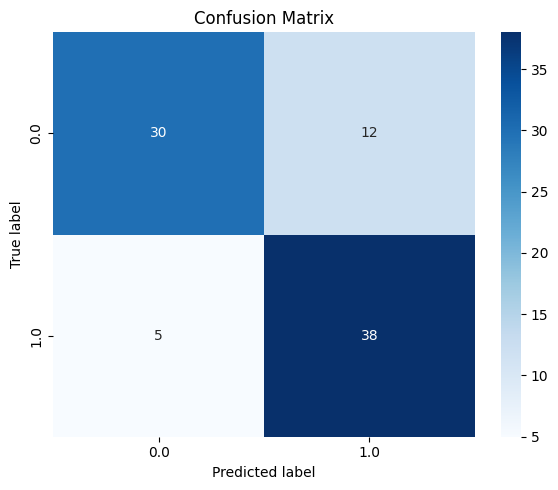


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF_LD_PM.csv


In [21]:
# HDF_LD_PM
HDF_LD_PM = run_stability_test_metrics_only(data_types=['HDF', 'LD', 'PM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.8911915421485901     │
│         val_loss          │    0.8911915421485901     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:07<00:00, 42.57s/it, Iteration=3, Best Loss=0.891]

[INFO] current best val loss: 0.8911915421485901; best params: {'latent_dim': 59, 'hidden_dim_factor': 0.47081105350777847, 'lr': 0.008242801897949485, 'supervisor_hidden_dim': 25, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


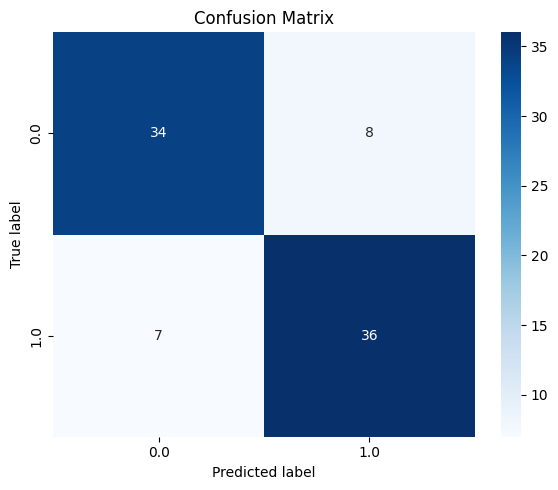


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF_LD_BM.csv


In [22]:
# HDF_LD_BM
HDF_LD_BM = run_stability_test_metrics_only(data_types=['HDF', 'LD', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │     0.299572229385376     │
│         val_loss          │     0.299572229385376     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:37<00:00, 52.40s/it, Iteration=3, Best Loss=0.3]  

[INFO] current best val loss: 0.299572229385376; best params: {'latent_dim': 58, 'hidden_dim_factor': 0.46596675487175, 'lr': 0.007688493605474894, 'supervisor_hidden_dim': 22, 'epochs': 300, 'batch_size': 128} since 0 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


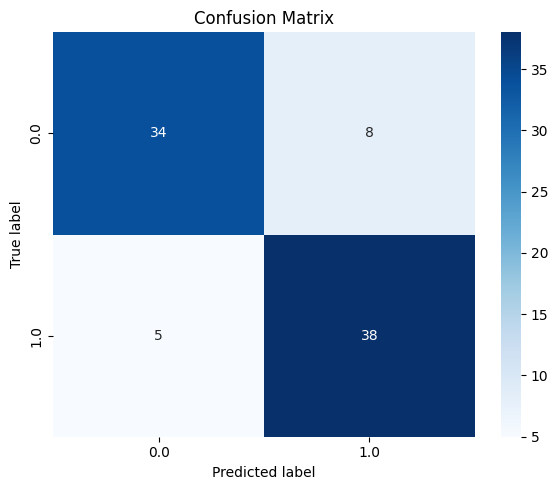


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF_PM_BM.csv


In [23]:
# HDF_PM_BM
HDF_PM_BM = run_stability_test_metrics_only(data_types=['HDF', 'PM', 'BM'])

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.6575146913528442     │
│         val_loss          │    0.6575146913528442     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:06<00:00, 42.01s/it, Iteration=3, Best Loss=0.25]

[INFO] current best val loss: 0.2497648298740387; best params: {'latent_dim': 58, 'hidden_dim_factor': 0.4617926354660924, 'lr': 0.009855654921681223, 'supervisor_hidden_dim': 24, 'epochs': 300, 'batch_size': 128} since 1 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


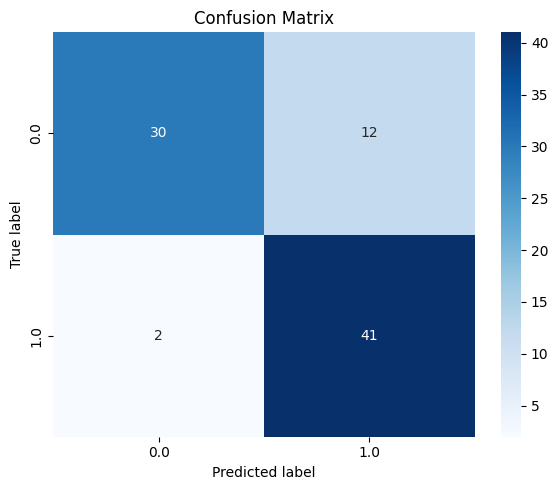


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\LD_PM_BM.csv


In [24]:
# LD_PM_BM
LD_PM_BM = run_stability_test_metrics_only(data_types=['LD', 'PM', 'BM'])

# 4 blocks

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.7178465127944946     │
│         val_loss          │    0.7178465127944946     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 3/3 [02:37<00:00, 52.55s/it, Iteration=3, Best Loss=0.248]


[INFO] current best val loss: 0.247910276055336; best params: {'latent_dim': 57, 'hidden_dim_factor': 0.46631591289016505, 'lr': 0.008651476861856898, 'supervisor_hidden_dim': 24, 'epochs': 300, 'batch_size': 128} since 2 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


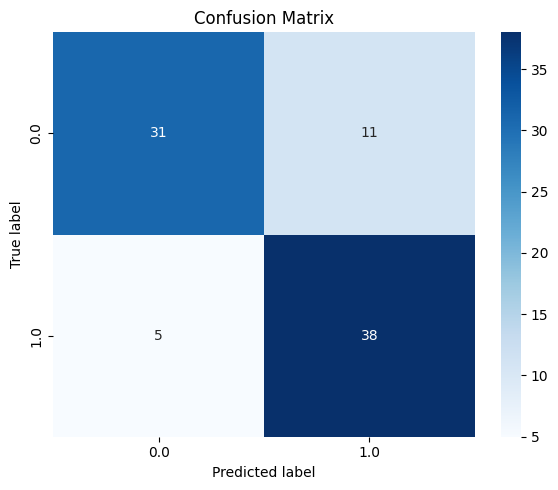


✅ Stability test finished. 5 rows of metrics collected.
📁 Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data\HDF_LD_PM_BM.csv


In [26]:
# HDF_LD_PM_BM
HDF_LD_PM_BM = run_stability_test_metrics_only(data_types=['HDF', 'LD', 'PM', 'BM'])


In [42]:
HDF_LD_PM_BM

metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.941156,0.921405,0.819398,0.822786,0.642557,0.824130,0.823529
1,1,0.914881,0.905765,0.806541,0.806924,0.619261,0.837323,0.811765
2,42,0.925241,0.947324,0.885452,0.882549,0.764934,0.886652,0.882353
3,48,0.915620,0.903010,0.817447,0.822034,0.641148,0.826413,0.823529
4,2023,0.918348,0.913621,0.810908,0.810663,0.622851,0.817807,0.811765


In [44]:
LD_PM_BM

metric,seed,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
0,0,0.959928,0.947046,0.839186,0.844926,0.687765,0.854877,0.847059
1,1,0.929660,0.920732,0.805710,0.805306,0.618620,0.848261,0.811765
2,42,0.947662,0.950948,0.865663,0.858667,0.720088,0.873895,0.858824
3,48,0.894123,0.902453,0.822464,0.829823,0.660388,0.861708,0.835294
4,2023,0.936859,0.936323,0.833887,0.832744,0.669628,0.854578,0.835294


✅ Loaded: BM ← BM.csv
✅ Loaded: HDF ← HDF.csv
✅ Loaded: HDF_BM ← HDF_BM.csv
✅ Loaded: HDF_LD ← HDF_LD.csv
✅ Loaded: HDF_LD_BM ← HDF_LD_BM.csv
✅ Loaded: HDF_LD_PM ← HDF_LD_PM.csv
✅ Loaded: HDF_LD_PM_BM ← HDF_LD_PM_BM.csv
✅ Loaded: HDF_PM ← HDF_PM.csv
✅ Loaded: HDF_PM_BM ← HDF_PM_BM.csv
✅ Loaded: LD ← LD.csv
✅ Loaded: LD_BM ← LD_BM.csv
✅ Loaded: LD_PM ← LD_PM.csv
✅ Loaded: LD_PM_BM ← LD_PM_BM.csv
✅ Loaded: PM ← PM.csv
✅ Loaded: PM_BM ← PM_BM.csv


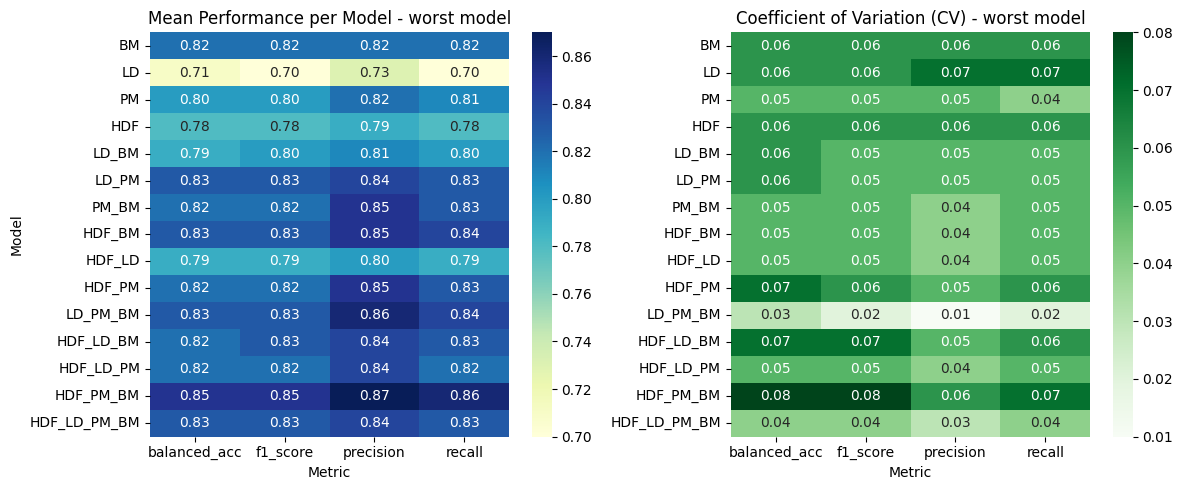

In [60]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 读取文件夹中所有 CSV 文件 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

model_names = []
dfs = {}

# === 2. 加载所有文件到字典，并创建变量 ===
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    var_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)
    dfs[var_name] = df
    globals()[var_name] = df
    model_names.append(var_name)
    print(f"✅ Loaded: {var_name} ← {file}")

# === 3. 计算均值和 CV（标准差 / 均值），保留两位小数 ===
metrics = ['balanced_acc', 'f1_score', 'precision', 'recall']
mean_data = {}
cv_data = {}

for name, df in dfs.items():
    mean_data[name] = {}
    cv_data[name] = {}
    for metric in metrics:
        values = df[metric]
        mean_val = values.mean()
        std_val = values.std()
        cv_val = std_val / mean_val if mean_val != 0 else np.nan
        mean_data[name][metric] = round(mean_val, 2)
        cv_data[name][metric] = round(cv_val, 2)

# === 4. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
cv_df = pd.DataFrame(cv_data).T

# ✅ 排序行顺序：按变量名字母数升序排列
sorted_index = sorted(mean_df.index, key=len)
mean_df = mean_df.loc[sorted_index]
cv_df = cv_df.loc[sorted_index]

# === 5. 可视化热图（颜色交换） ===
plt.figure(figsize=(12, 5))

# 热图 1：平均值（用 YlGnBu）
plt.subplot(1, 2, 1)
sns.heatmap(mean_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Mean Performance per Model - worst model")
plt.xlabel("Metric")
plt.ylabel("Model")

# 热图 2：CV（用 Greens）
plt.subplot(1, 2, 2)
sns.heatmap(cv_df, annot=True, fmt=".2f", cmap="Greens")
plt.title("Coefficient of Variation (CV) - worst model")
plt.xlabel("Metric")
plt.ylabel("")

plt.tight_layout()
plt.show()


✅ Loaded: BM ← BM.csv
✅ Loaded: HDF ← HDF.csv
✅ Loaded: HDF_BM ← HDF_BM.csv
✅ Loaded: HDF_LD ← HDF_LD.csv
✅ Loaded: HDF_LD_BM ← HDF_LD_BM.csv
✅ Loaded: HDF_LD_PM ← HDF_LD_PM.csv
✅ Loaded: HDF_LD_PM_BM ← HDF_LD_PM_BM.csv
✅ Loaded: HDF_PM ← HDF_PM.csv
✅ Loaded: HDF_PM_BM ← HDF_PM_BM.csv
✅ Loaded: LD ← LD.csv
✅ Loaded: LD_BM ← LD_BM.csv
✅ Loaded: LD_PM ← LD_PM.csv
✅ Loaded: LD_PM_BM ← LD_PM_BM.csv
✅ Loaded: PM ← PM.csv
✅ Loaded: PM_BM ← PM_BM.csv


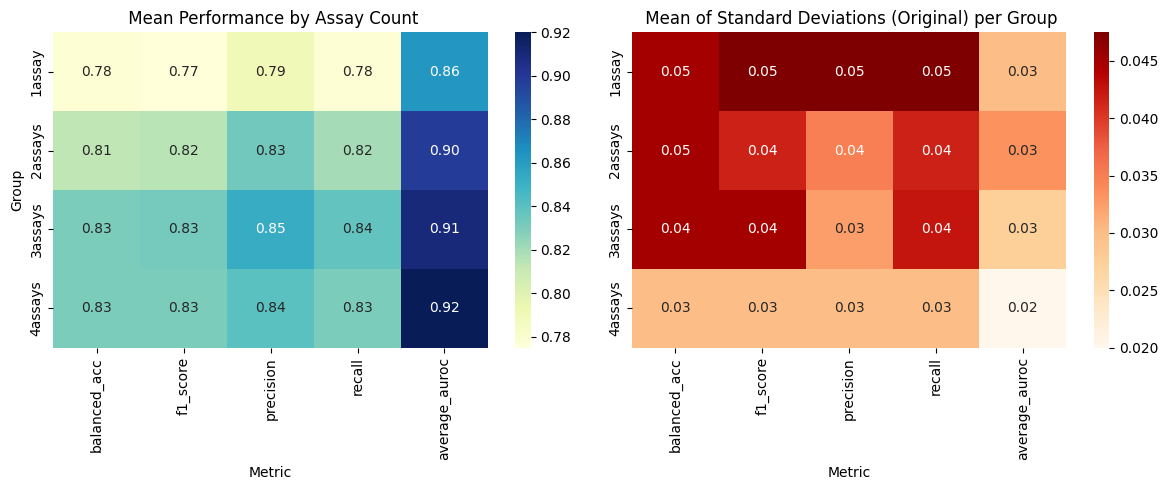

In [17]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 加载 CSV 文件 ===
folder_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\flexynesis prediction data"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

model_names = []
dfs = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    var_name = os.path.splitext(file)[0].replace(" ", "_").replace("-", "_")
    df = pd.read_csv(file_path)
    dfs[var_name] = df
    globals()[var_name] = df
    model_names.append(var_name)
    print(f"✅ Loaded: {var_name} ← {file}")

# === 2. 指标列表 ===
metrics = ['balanced_acc', 'f1_score', 'precision', 'recall', 'average_auroc']

# === 3. 计算均值、标准差、CV ===
mean_data = {}
std_data = {}

for name, df in dfs.items():
    mean_data[name] = {}
    std_data[name] = {}
    for metric in metrics:
        if metric in df.columns:
            values = df[metric]
            mean_val = values.mean()
            std_val = values.std()
            mean_data[name][metric] = round(mean_val, 2)
            std_data[name][metric] = round(std_val, 2)
        else:
            mean_data[name][metric] = np.nan
            std_data[name][metric] = np.nan

# === 4. 转为 DataFrame ===
mean_df = pd.DataFrame(mean_data).T
std_df = pd.DataFrame(std_data).T  # 注意：这里是“原始每个模型的 std”

# === 5. 分类模型：按下划线数量自动归类 ===
assay_groups = {}
for model_name in mean_df.index:
    assay_count = model_name.count('_') + 1
    group_key = f"{assay_count}assay" if assay_count == 1 else f"{assay_count}assays"
    assay_groups.setdefault(group_key, []).append(model_name)

# === 6. 计算分组的 mean（表现均值） & 平均 std（不是组内 std，而是 std 的平均） ===
group_mean_df = pd.DataFrame(columns=metrics)
group_avg_std_df = pd.DataFrame(columns=metrics)

for group_name, model_list in assay_groups.items():
    # 平均指标值
    selected_mean = mean_df.loc[model_list]
    group_mean_df.loc[group_name] = selected_mean.mean()
    
    # 原始 std 的均值
    selected_std = std_df.loc[model_list]
    group_avg_std_df.loc[group_name] = selected_std.mean()

# === 7. 可视化 ===
plt.figure(figsize=(12, 5))

# 🔵 均值热图
plt.subplot(1, 2, 1)
sns.heatmap(group_mean_df, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title(' Mean Performance by Assay Count')
plt.xlabel("Metric")
plt.ylabel("Group")

# 🔴 方差平均热图
plt.subplot(1, 2, 2)
sns.heatmap(group_avg_std_df, annot=True, cmap='OrRd', fmt=".2f")
plt.title(' Mean of Standard Deviations (Original) per Group')
plt.xlabel("Metric")
plt.ylabel("")

plt.tight_layout()
plt.show()


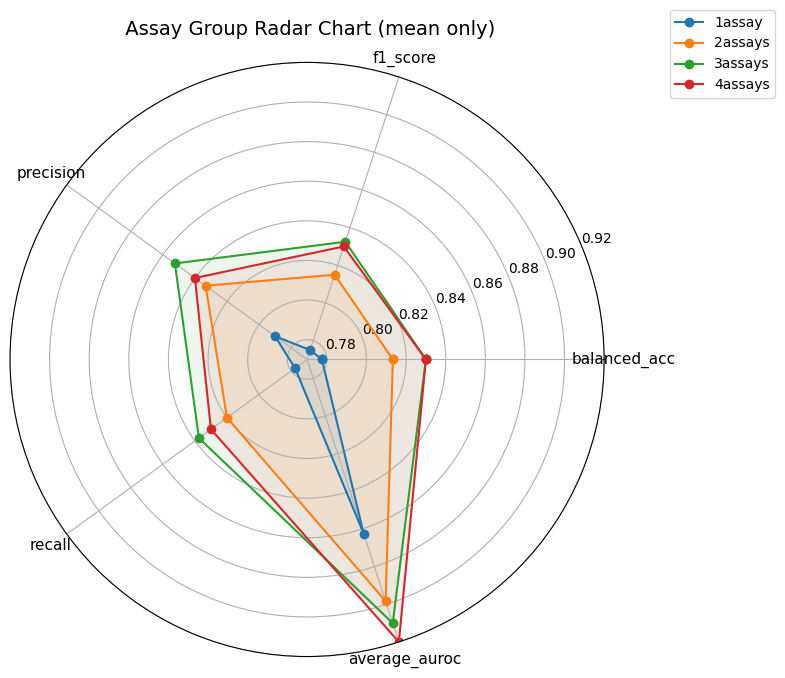

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ 排除 average_aupr，保持其它指标顺序一致
metrics = [col for col in group_mean_df.columns 
           if col not in ['mean', 'average_aupr']]

# 2️⃣ 角度设置 & 闭合
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # 闭合雷达图

# 3️⃣ 绘图
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# 4️⃣ 绘制每个组的线和阴影
for group_name in group_mean_df.index:
    values = group_mean_df.loc[group_name, metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, marker='o', label=group_name)
    ax.fill(angles, values, alpha=0.08)

# 5️⃣ 设置坐标轴和格式
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0.77, 0.92)  # 保持一致的雷达图范围
ax.set_title(" Assay Group Radar Chart (mean only)", pad=20, fontsize=14)

# 6️⃣ 图例 & 展示
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
